In [1]:
import json
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, KMeans
import itertools
import seaborn as sns
import matplotlib.patches as mpatches
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from nltk.stem import WordNetLemmatizer
import pickle
import nltk
import unicodedata
import re
seed = 208

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Exploratory Data Analysis

In [2]:
# Load data
f = open('train.json','r', encoding = 'utf-8')
data = pd.read_json(f)
data

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


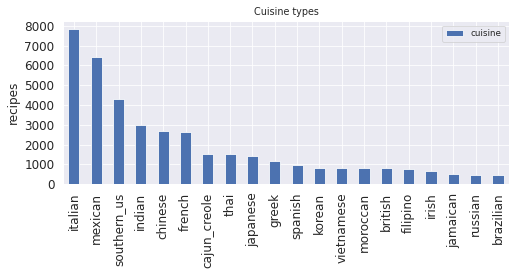

In [21]:
# Visualize the number of cuisines 
ax = data['cuisine'].value_counts().plot(kind='bar', title ="Cuisine types", figsize=(8, 3), legend=True, fontsize=12)
ax.set_ylabel("recipes", fontsize=12)
plt.show()

In [0]:
# Look at the top 50 ingredients
a = data['ingredients']
ax = list(itertools.chain.from_iterable(a))
listofingredients = Counter(ax)
# Convert Counter Object to dataframe
ingredientsCount = pd.DataFrame.from_dict(listofingredients, orient='index').reset_index()
# Change the column name
ingredientsCount.columns = ["ingredient", "count"]
# Get the top 50 rows after sorting
top50food = ingredientsCount.sort_values(by="count", ascending=False).head(50)

In [0]:
def show_values_on_hbars(splot, size=0.4):
    """
        plot numerical values on a seaborn vertical plot
    
    Argument:
        splot : a seaborn plot
        size (float): the size of the text
    Return:
        None
    """
    # Loop through each patch in the plot
    for patch in splot.patches:
        # Get the dimension to locate the text
        pt_x = patch.get_x() + patch.get_width() + float(size)
        pt_y = patch.get_y() + patch.get_height()
        # Get the value of the bar
        value = int(patch.get_width())
        # Add the text
        ax.text(pt_x, pt_y, value, ha="left") 

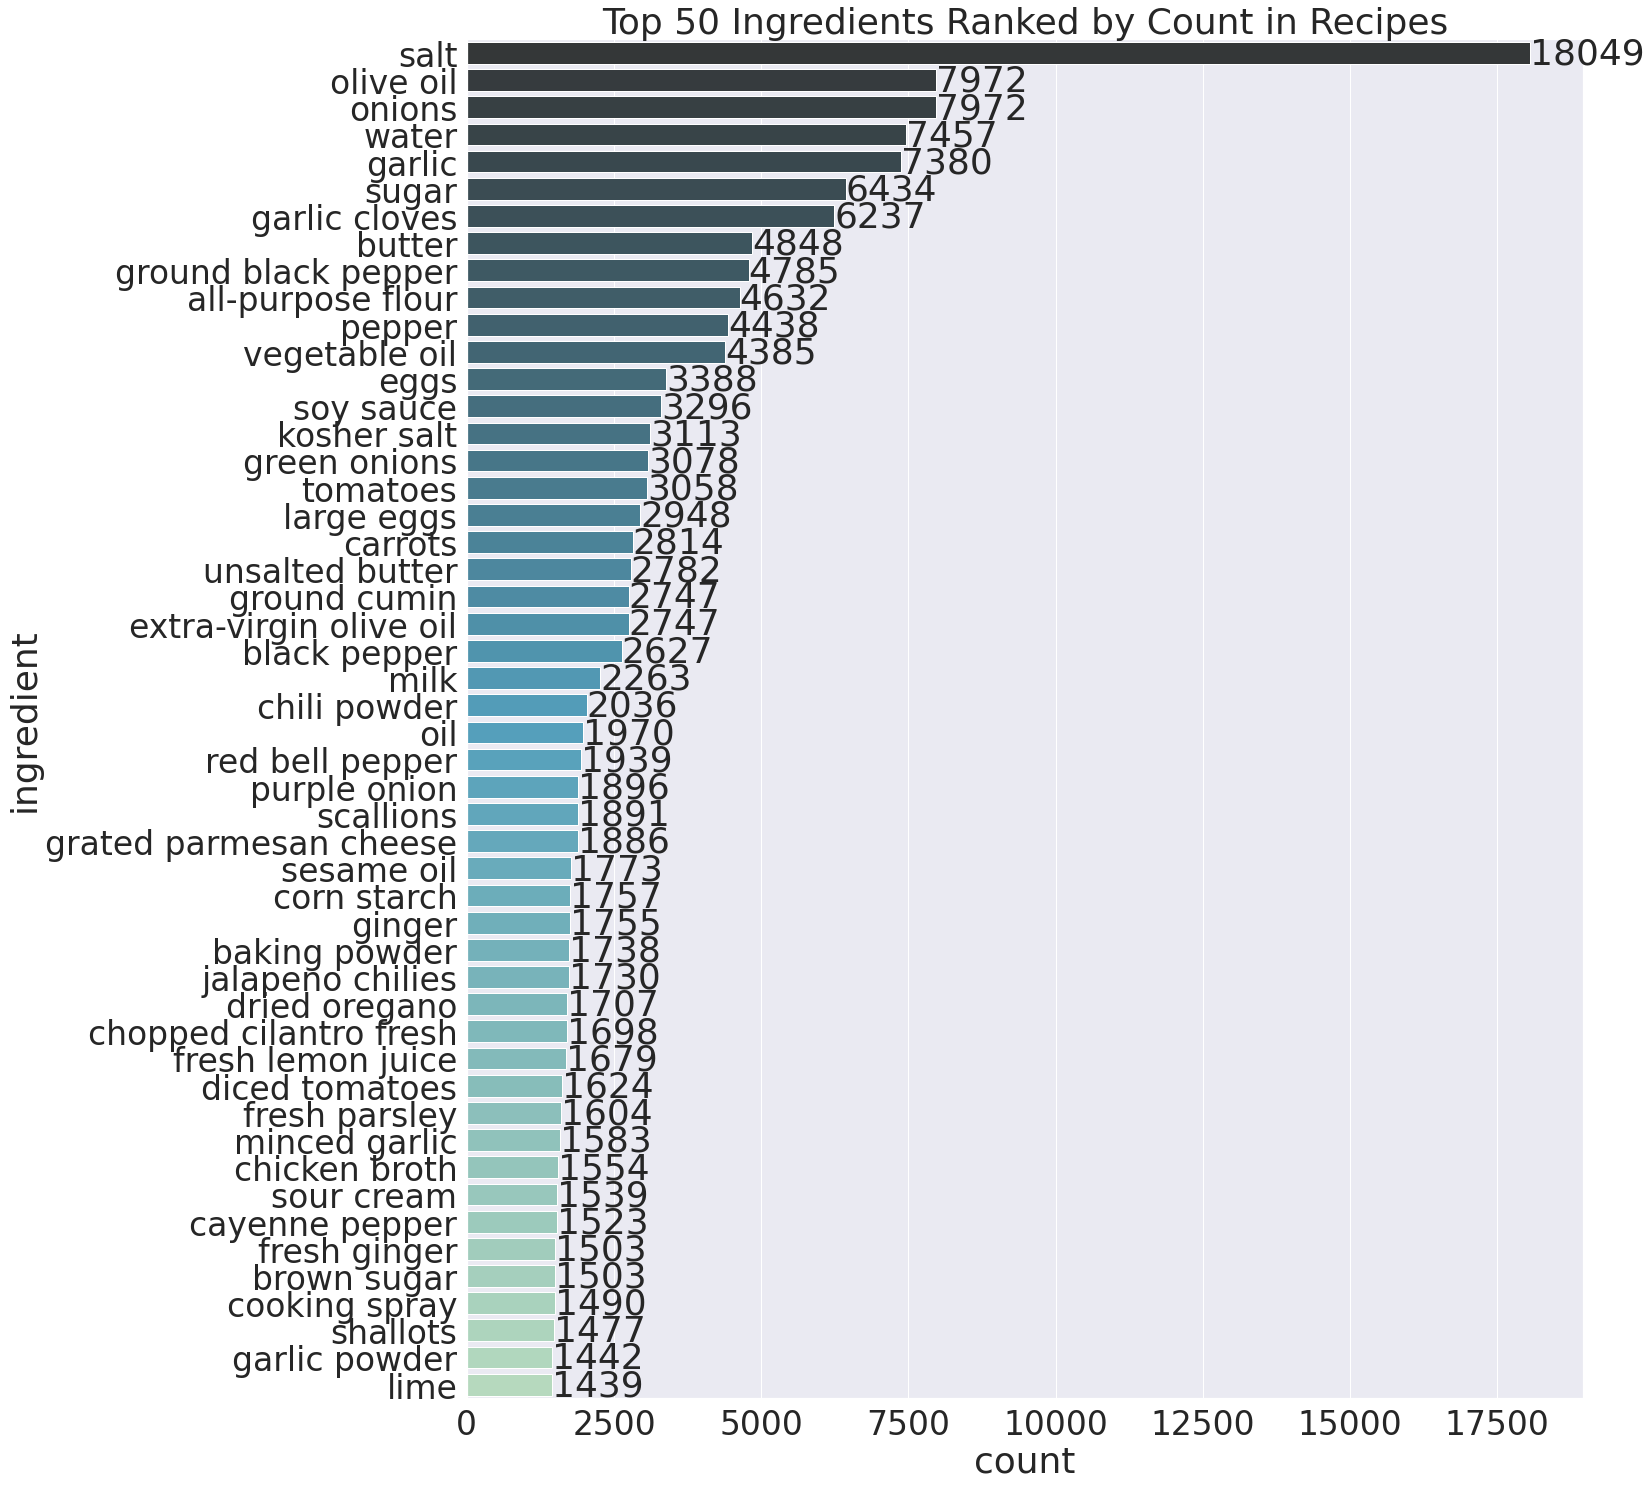

In [25]:
# Plot out the top 50 ingredients
fig, ax = plt.subplots(figsize=(20,25))
sns.set(font_scale=3) 
s = sns.barplot(x="count", y="ingredient", palette="GnBu_d", data=top50food)
s.set_title('Top 50 Ingredients Ranked by Count in Recipes')
show_values_on_hbars(s, 0.3)

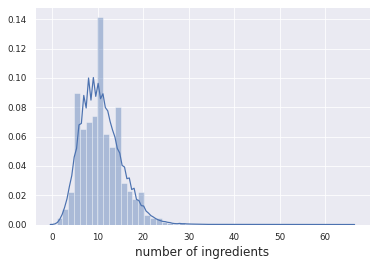

In [26]:
# Add the number of ingredients to the data
data["number of ingredients"] = data["ingredients"].apply(len)
# Plot the distribution of the number of ingredients
sns.set_context("paper", rc={"font.size":12,"axes.labelsize":12})# adjust the font size  
sns.distplot(data["number of ingredients"])# plot the graph

Text(0.5, 1.0, 'The number of cuisines that have over 30 ingredients in Recipes')

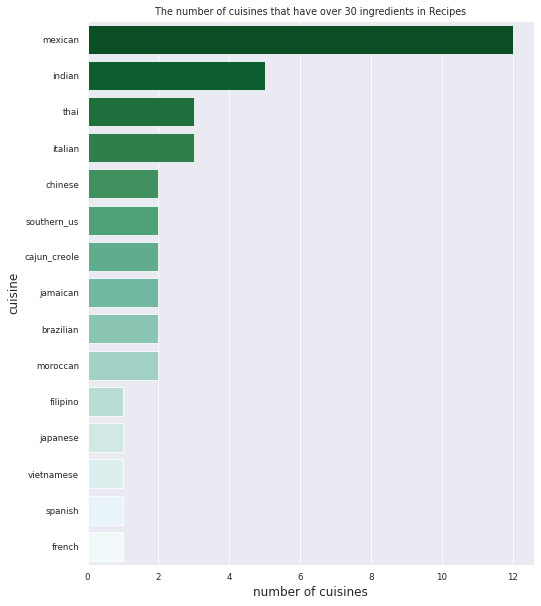

In [27]:
# Show all the cuisine that has more than 30 ingredients
over30ingredients = Counter(data[data["number of ingredients"]>30]["cuisine"])
over30ingredients = pd.DataFrame.from_dict(over30ingredients, orient='index').reset_index()
# Change the column name
over30ingredients.columns = ["cuisine", "number of cuisines"]
# Sort values from highest to lowest
over30ingredients = over30ingredients.sort_values(by="number of cuisines", ascending = False)
fig, ax = plt.subplots(figsize=(8,10))
s = sns.barplot(x="number of cuisines", y="cuisine", palette="BuGn_r", data=over30ingredients)
sns.set_context("paper", rc={"font.size":15,"axes.labelsize":15})# adjust the font size  
s.set_title('The number of cuisines that have over 30 ingredients in Recipes')

**Preprocessing steps:**
1. Turning to lower case
2. remove all ( .oz) description
3. Lemmatizing the string
4. De-accent the string
5. Strip out everything else besides letter

In [0]:
# Instantiate an tokenizer object and an lemmatizer object
wpt = nltk.WordPunctTokenizer()
lemmatizer = WordNetLemmatizer()
def clean(text):
  """
    this function applies different function to manipulate a strnig 
  Arg:
    text(str): a string
  Return:
    text(str): a "cleaned" string
  """
  # Converts them into lower case
  text = text.lower()
  # grouping together the different inflected forms of a word
  text = lemmatizer.lemmatize(text,pos='n')
  # de-accent the words
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  # Remove everything else besides letter 
  text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
  return text 

def text_preprocess(data):
  """
    preprocess the ingredients names and preserves the structure of the original data
   Arguemnts:
    data (dataframe): a dataframe that contains all the ingredients in the data
   Return:
    cleaned_corpus(list): a list of lists of ingredients that has been preprocessed.
  """
  cleaned_corpus = list()
  # Loop through every list of ingredients
  for ls in data["ingredients"]:
    clean_ls = list()
    # Loop through every ingredient in the list
    for ingred_names in ls:
      dummy_ls = []
      # remove this description from the ingredients
      ingred_names =  re.sub(r'\(.*oz.\)','', ingred_names)
      # If there are more than one word in that string, we split them 
      if " " in ingred_names:
        list_of_names = ingred_names.split(" ")
        for ingredient in  list_of_names:
          cleaned_txt = clean(ingredient)
          dummy_ls.append(cleaned_txt)
        # Join the string together and append that to a list
        clean_ls.append(" ".join(dummy_ls))
      # If not, we can clean it directly
      else:
        cleaned_txt = clean(ingred_names)
        # Append the cleaned name to a list
        clean_ls.append(cleaned_txt)
    cleaned_corpus.append(clean_ls)
  return cleaned_corpus    

In [0]:
corpus = text_preprocess(data)
# Flatten a list of lists
f_corpus = [ y for x in corpus for y in x]
# Turn the large dataset into iterable
corpus_iter = iter(f_corpus)

**Apply the following find the vectorial representation**

* Tfidf vectorizer
* Count vectorizer
* Normalized Count vectorizer
* Word2vec model
* Normalized Word2vec model

**1. Tfidf vectorizer**

In [0]:
# convert text to word frequency vectors with TfidfVectorizer.
vectorizer = TfidfVectorizer() 
tfidf = vectorizer.fit_transform(corpus_iter)
tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())

**2. Counter Vectorizer**

In [0]:
# convert text to word count vectors with CountVectorizer.
vec = CountVectorizer()
X = vec.fit(f_corpus)
filename = "countvec.pkl"
with open(filename, 'wb') as fout:
    pickle.dump(X, fout)
    
with open('countvec.pkl', 'rb') as f:
    cv = pickle.load(f)
X = cv.transform(f_corpus)
dtm = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

**3. Normalized Counter Vectorizer**

In [0]:
norm_dtm = Normalizer().fit(dtm)
norm_dtm = norm_dtm.transform(dtm)

4. Word2Vec model

In [0]:
# Word2vec model parameters
# Word vector dimensionality       
num_features = 300    # Word vector dimensionality  
# 50% of the corpus                                 
min_word_count = 3 
# Number of CPUs   
num_workers = 4       
# Context window size; 
# let's use avg recipte size   
context = 10
# threshold for configuring which higher-frequency words are randomly downsampled                                                                                         
downsampling = 1e-3   

# Initialize and train the model 
word2vec = Word2Vec(corpus, workers=num_workers, \
                 size=num_features, min_count = min_word_count, \
                 window = context, sample = downsampling)

# init_sims will make the model much more memory-efficient.
word2vec.init_sims(replace=True)

In [8]:
word2vec.wv.vocab.keys()

dict_keys(['romaine lettuce', 'black olive', 'grape tomato', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo bean', 'feta cheese crumbles', 'plain flour', 'ground pepper', 'salt', 'tomato', 'ground black pepper', 'thyme', 'egg', 'green tomato', 'yellow corn meal', 'milk', 'vegetable oil', 'mayonaise', 'cooking oil', 'green chilies', 'grilled chicken breast', 'garlic powder', 'yellow onion', 'soy sauce', 'butter', 'chicken liver', 'water', 'wheat', 'black pepper', 'shallot', 'cornflour', 'cayenne pepper', 'onion', 'garlic paste', 'lemon juice', 'chili powder', 'passata', 'oil', 'ground cumin', 'boneless chicken skinless thigh', 'garam masala', 'double cream', 'natural yogurt', 'bay leaf', 'sugar', 'fresh ginger root', 'ground cinnamon', 'vanilla extract', 'ground ginger', 'powdered sugar', 'baking powder', 'olive oil', 'medium shrimp', 'chopped cilantro', 'jalapeno chilies', 'flat leaf parsley', 'skirt steak', 'white vinegar', 'sea salt', 'chorizo sausage', 'pistachio nut', '

5. Normalized Word2Vec model

In [33]:
norm_word2vec = 

Index(['abalone', 'abbamele', 'absinthe', 'abura', 'acai', 'accent',
       'accompaniment', 'achiote', 'acid', 'acinus',
       ...
       'yuzukosho', 'za', 'zatarain', 'zatarains', 'zero', 'zest', 'zesty',
       'zinfandel', 'ziti', 'zucchini'],
      dtype='object', length=2808)

**PCA decomposition**

In [34]:
# Run the PCA decomposition
pca = PCA(n_components=2)
# Implement PCA on the standardized data
result = pca.fit_transform(tfidf)
# Check the loadings
loadings = pd.DataFrame(pca.components_.T, columns= ['PC1', 'PC2'], index=tfidf.columns)
# Check which variable has the most loading in the first component
loadings.sort_values(by = "PC1", ascending= False)

,PC1,PC2
flour,0.257797,-0.067825
sugar,0.237912,0.172667
egg,0.236803,-0.035347
purpose,0.221862,-0.067208
all,0.221736,-0.067261
...,...,...
onion,-0.158348,0.011221
tomato,-0.164900,-0.141987
garlic,-0.165959,0.010188
fresh,-0.173696,-0.080464


In [35]:
# Check which variable has the most loading in the second component
loadings.sort_values(by = "PC2", ascending= False)

,PC1,PC2
sauce,-0.091036,0.341833
soy,-0.041002,0.301042
sesame,-0.030045,0.255005
rice,-0.056367,0.189432
ginger,-0.055629,0.184640
...,...,...
grated,0.008188,-0.132644
tomato,-0.164900,-0.141987
parmesan,-0.020052,-0.157790
olive,-0.149895,-0.211432


In [0]:
color_parlette = {"#000000", # blak
                "#FFFF00", #yellow
                "#1CE6FF", #cyan
                "#FF34FF", #pink 
                "#FF4A46", #red
               "#FFC300",  # green forest
                "#006FA6", # blue ocean
                "#A30059",# purple
               "#FFDBE5",  #light pink
                "#7A4900",  # gold or brown 
                "#0000A6", # blue electric 
                "#63FFAC", # green phospho
                "#B79762", #brown
                "#EEC3FF", #  
                "#8FB0FF", # light blue 
                "#997D87", #violet
               "#5A0007", 
                "#809693", 
                "#FEFFE6", #ligt yellow
                "#1B4400"}

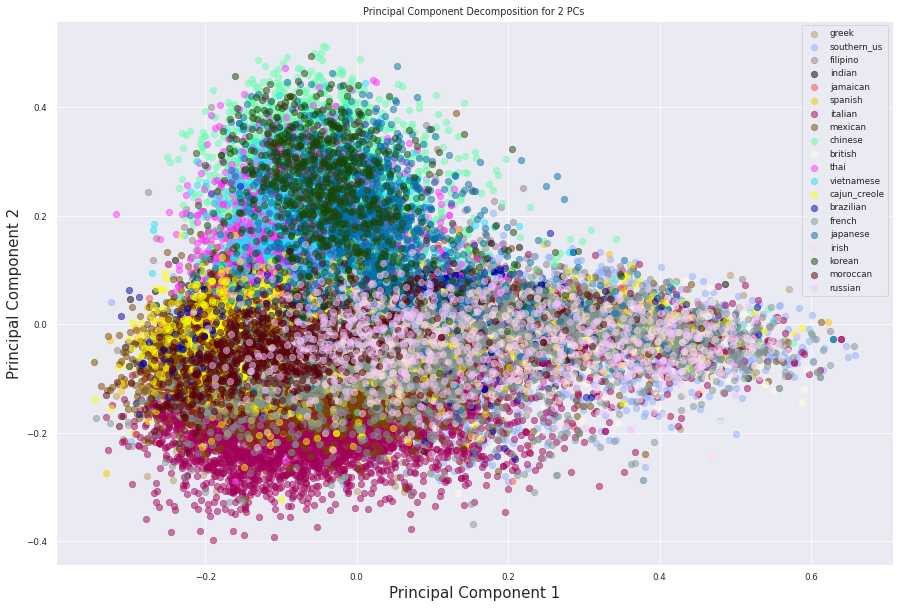

In [37]:
# Plot the two principal components
# Configure the plot details
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Principal Component Decomposition for 2 PCs')
# Get the task name
cuisines = data.cuisine.unique()
# Create a dataframe of the pca result for plot
components = pd.DataFrame(result, columns = ['PC1', 'PC2'])
# Plot data points corresponding to each task in the components
for cuisine, color in zip(cuisines,color_parlette):
    idx = data['cuisine'] == cuisine
    ax.scatter(components.loc[idx,'PC1'],
               components.loc[idx,'PC2'],
               c = color,alpha=0.5,cmap='hsv', s = 40)
ax.legend(cuisines)
plt.show()

**K Means Clustering for mapping labels**

In [38]:
# Apply K-means clustering for tfidf
kmeans = KMeans(n_clusters=20, random_state=seed).fit(tfidf)
kmeans.labels_

array([ 7,  1,  5, ..., 11,  2,  0], dtype=int32)

In [39]:
# Instantiate the encoder class
le = LabelEncoder()
# Get the encoded labels for each task
y = le.fit_transform(data['cuisine'])
# Show which task each label corresponds to
le.inverse_transform(np.arange(20))

array(['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino',
       'french', 'greek', 'indian', 'irish', 'italian', 'jamaican',
       'japanese', 'korean', 'mexican', 'moroccan', 'russian',
       'southern_us', 'spanish', 'thai', 'vietnamese'], dtype=object)

In [40]:
# creating a confusion matrix 
cm = confusion_matrix(y, kmeans.labels_, labels=np.arange(20))
cm

array([[  56,   16,    1,   25,   11,    7,    1,   15,    6,    7,    0,
         159,   19,   16,    0,   26,   18,   79,    1,    4],
       [   3,   17,    0,    0,   44,    2,    7,    2,  105,   13,    6,
         237,    1,  139,    1,   43,    4,  147,    1,   32],
       [ 746,   79,    3,   11,   51,   82,    8,   63,   17,   30,    7,
         267,    0,   49,    1,   44,   22,   27,    0,   39],
       [  29,   14, 1698,    6,   20,  131,   11,    3,   12,    8,    1,
         221,   29,   23,  398,   14,    3,   32,    1,   19],
       [  39,   27,  264,    2,   26,   23,    1,    8,   13,    4,    3,
         182,   57,   13,    7,    8,    1,   64,    0,   13],
       [  29,   23,    4,    6,  251,   55,    6,  178,   38,  205,    8,
         526,    0,  263,    0,  542,   71,  380,    0,   61],
       [  19,   66,    0,    5,   28,   47,    5,  484,   26,  196,    1,
         152,    0,   34,    1,   46,   40,   10,    0,   15],
       [  30,  420,    9,   67,    9,   9

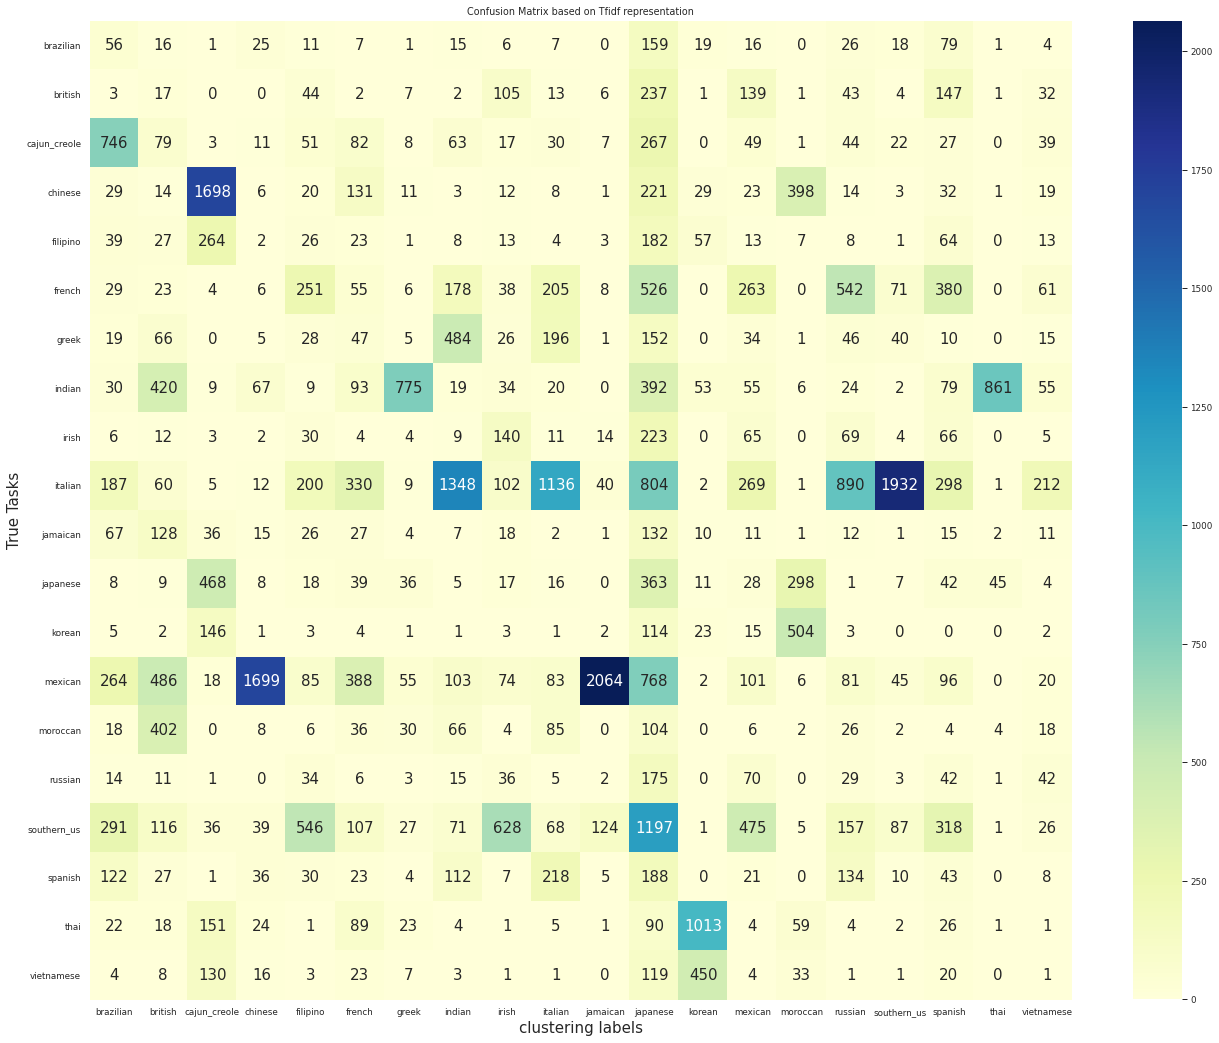

In [41]:
# plot confusion matrix
df_cm= pd.DataFrame(cm, index = le.inverse_transform(np.arange(20))  ,columns = le.inverse_transform(np.arange(20)))
plt.figure(figsize = (22,18))
ax = sns.heatmap(df_cm,annot=True, fmt="d",cmap="YlGnBu")
ax.set(ylabel='True Tasks', xlabel='clustering labels', title='Confusion Matrix based on Tfidf representation')
plt.show()

In [42]:
# Apply K-means clustering for dtm
kmeans_dtm = KMeans(n_clusters=20, random_state=seed).fit(dtm)
kmeans_dtm.labels_

array([ 7, 11, 16, ..., 17, 13,  4], dtype=int32)

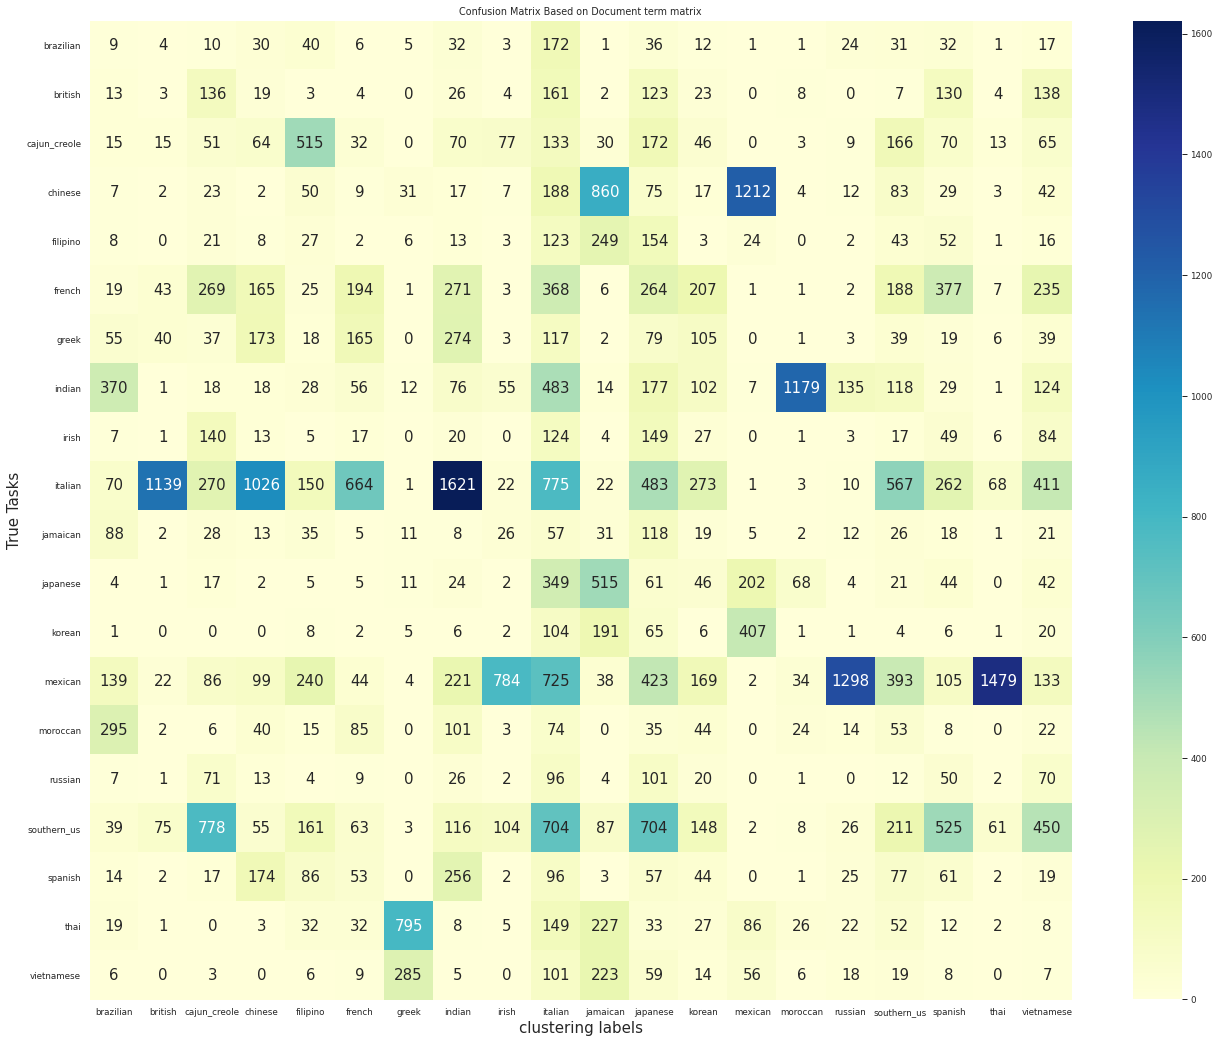

In [43]:
# creating a confusion matrix 
cm_dtm = confusion_matrix(y, kmeans_dtm.labels_, labels=np.arange(20))
# plot confusion matrix
df_cm= pd.DataFrame(cm_dtm, index = le.inverse_transform(np.arange(20))  ,columns = le.inverse_transform(np.arange(20)))
plt.figure(figsize = (22,18))
ax = sns.heatmap(df_cm,annot=True, fmt="d",cmap="YlGnBu")
ax.set(ylabel='True Tasks', xlabel='clustering labels', title='Confusion Matrix Based on Document term matrix')
plt.show()

In [44]:
# Randomly split the training and testing data
X_train, X_test, y_train, y_test = train_test_split(dtm, y, test_size = 0.3, random_state = seed)
# define model
model = LogisticRegression(multi_class='ovr')
# fit model
model.fit(X_train,  y_train)
# make predictions
yhat = model.predict(X_test)
# model accuracy for X_test   
accuracy = model.score(X_test, y_test) 
# creating a confusion matrix 
cm = confusion_matrix(y_test, yhat)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [45]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.79      0.55      0.64       141
           1       0.58      0.34      0.43       244
           2       0.78      0.68      0.73       425
           3       0.80      0.85      0.82       759
           4       0.79      0.59      0.67       235
           5       0.60      0.63      0.61       810
           6       0.80      0.72      0.76       381
           7       0.86      0.91      0.89       965
           8       0.67      0.51      0.58       211
           9       0.80      0.90      0.85      2372
          10       0.87      0.67      0.76       166
          11       0.80      0.68      0.73       386
          12       0.82      0.72      0.76       246
          13       0.89      0.93      0.91      1904
          14       0.84      0.75      0.79       236
          15       0.63      0.41      0.50       147
          16       0.71      0.82      0.76      1309
          17       0.68    

In [46]:
# Spot-Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('NB', GaussianNB()))
#
# models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.780395 (0.009053)
LDA: 0.735354 (0.008923)
KNN: 0.628569 (0.008312)
RF: 0.748572 (0.004304)
NB: 0.260191 (0.010848)


In [0]:
model = SVC(kernel="linear", decision_function_shape = 'ovr')
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
# model accuracy for X_test   
accuracy = model.score(X_test, y_test)

In [0]:
print(classification_report(y_test, yhat))

**Feedforward neural networks with SGD and Adam optimizers**

In [0]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

In [0]:
# Randomly split the training and testing data
X_train, X_test, y_train, y_test = train_test_split(tfidf, y, test_size = 0.3, random_state = seed, stratify=y)

In [0]:
# Standardlize the data
#scaler = StandardScaler()
#X_train_std = scaler.fit_transform(X_train)
#X_test_std = scaler.fit_transform(X_test)
# determine the number of input features
n_features = X_train.shape[1]

In [0]:
# define model
model = Sequential()
model.add(Dense(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dropout(0.8))
model.add(Dense(80, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.6))
model.add(Dense(40, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='softmax'))
# Define optimizer
sgd = SGD(learning_rate=0.001, decay = 1e-6, momentum=0.8, nesterov = True)
# compile the model
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
# fit the model
history = model.fit(X_train_std, y_train, epochs=1000, batch_size=128, verbose=0, validation_split=0.3)

In [0]:
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [0]:
# evaluate the model
loss, acc = model.evaluate(X_test_std, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

In [0]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_std, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_std, verbose=0)

In [0]:
print(classification_report(y_test,yhat_classes))

In [0]:
# define model
model = Sequential()
model.add(Dense(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dropout(0.8))
model.add(Dense(80, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.6))
model.add(Dense(40, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='softmax'))
# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
# fit the model
history = model.fit(X_train_std, y_train, epochs=500, batch_size=128, verbose=0, validation_split=0.3)

In [0]:
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [0]:
# evaluate the model
loss, acc = model.evaluate(X_test_std, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

In [0]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_std, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_std, verbose=0)

In [0]:
print(classification_report(y_test,yhat_classes))

In [0]:
# define model
model = Sequential()
model.add(Dense(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dropout(0.5))
model.add(Dense(60, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(20, activation='softmax'))
# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
# fit the model
history = model.fit(X_train_std, y_train, epochs=10, batch_size=32, verbose=0, validation_split=0.3)

In [0]:
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [0]:
# evaluate the model
loss, acc = model.evaluate(X_test_std, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

In [0]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_std, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_std, verbose=0)

In [0]:
print(classification_report(y_test,yhat_classes))

**Word2vec model**

In [4]:
cleaned_corpus = list()

for ls in data["ingredients"]:
    clean_ls = list()
    for ingredient in ls:
        # remove this description from the ingredients
        ingredient =  re.sub(r'\(.*oz.\)','', ingredient)
        clean_ls.append(ingredient.strip())
    cleaned_corpus.append(clean_ls)
        
len(cleaned_corpus)

39774

In [0]:
# Word2vec model parameters
# Word vector dimensionality       
num_features = 300    # Word vector dimensionality  
# 50% of the corpus                                 
min_word_count = 3 
# Number of CPUs   
num_workers = 4       
# Context window size; 
# let's use avg recipte size   
context = 10
# threshold for configuring which higher-frequency words are randomly downsampled                                                                                         
downsampling = 1e-3   

# Initialize and train the model 
model = Word2Vec(cleaned_corpus, workers=num_workers, \
                 size=num_features, min_count = min_word_count, \
                 window = context, sample = downsampling)

# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

In [9]:
len(model["green tomatoes"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


300

In [8]:
# Learned similarity
x = 'spinach'
b= 'broccoli'
a = 'bacon'
predicted = model.most_similar([x, b], [a])[0][0]
print(" {} is to  {} as {} is to {} ".format(a, b, x, predicted))

 bacon is to  broccoli as spinach is to noodles 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


**Plot TSNE to show the hi-dimensional learned embedding in a low dimensional space**

In [0]:
# Sort all the ingredient names in the model
document = sorted(model.wv.vocab.keys()) 
# Get the embedding tuple for each ingredient
emb_tuple = tuple([model[ingredient_name] for ingredient_name in document])
# Stack arrays in sequence vertically (row wise)
X = np.vstack(emb_tuple)
# Fit it to TSNE
X_tsne = TSNE(n_components=2).fit_transform(X)

In [0]:
counts_cuis = Counter(data["cuisine"]) # get the cuisine data
# Create a dictionary with cuisine name as keys and a list of ingredients with its number of count under each cuisine.
track_ingredients = dict(zip(counts_cuis.keys(), [list() for x in counts_cuis.keys()]))
for cui, ls in zip(data["cuisine"],data["ingredients"]):
    # append the number in the list
    clean_recipt = list()
    for ingred in ls:
      ingredient =  re.sub(r'\(.*oz.\)','', ingredient)
      clean_recipt.append(ingred.strip())
    track_ingredients[cui].extend(clean_recipt)
    
# Get the number of count for each item under each key
for label, tracking in track_ingredients.items():
    track_ingredients[label] = Counter(tracking)

In [0]:
def return_most_popular(v):
    cuisine = None
    record = 0
    for label, tracking in track_ingredients.items():
        norm_freq = float(tracking[v]) / float(counts_cuis[label])
        if norm_freq > record:
            cuisine = label
            record = norm_freq
    return cuisine

In [0]:
# Plot the TSNE
track_2color = {u'irish':"#000000", # blak
                u'mexican':"#FFFF00", #yellow
                u'chinese':"#1CE6FF", #cyan
                u'filipino': "#FF34FF", #pink 
                u'vietnamese':"#FF4A46", #red
                u'spanish':"#FFC300",  # green forest
                u'japanese':"#006FA6", # blue ocean
                u'moroccan':"#A30059",# purple
                u'french':"#FFDBE5",  #light pink
                u'greek': "#7A4900",  # gold or brown 
                u'indian':"#0000A6", # blue electric 
                u'jamaican':"#63FFAC", # green phospho
                u'british': "#B79762", #brown
                u'brazilian': "#EEC3FF", #  
                u'russian':"#8FB0FF", # light blue 
                u'cajun_creole':"#997D87", #violet
                u'thai':"#5A0007", 
                u'southern_us':"#809693", 
                u'korean':"#FEFFE6", #ligt yellow
                u'italian':"#1B4400"}

color_vector = list()
for v in document:
    cuisine = return_most_popular(v)
    color_vector.append(track_2color[cuisine])

#ensemble the legend
lgend = list()
for l, c in track_2color.items():
  lgend.append(mpatches.Patch(color=c, label=l))

sns.set_context("poster")
fig, ax = plt.subplots(figsize=(18,18))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color_vector, alpha=.6, s=60)
plt.legend(handles=lgend)